# Introduction

Welcome to Fredernick Lindemeyer's Project! Our focus revolves around implementing exploratory techniques of the models used to classify the brain waves -- we're identifying the "sentimental" explanation of the predictions that models make, which are often are obscured by the complex and near impossible to understand math.

We decided to focus on nicotine consumption based on previous research conducted on the impact of nicotine on brain waves. There is common consensus that there is a causal effect in the increase in alpha waves.

In general, we hypothesize an increase in alpha waves when Frederick, smokes with his vape. We plan on using two models, the EEGNet architecture which examplifies a black box model, and a basic logistic regression classifier, which corresponds to an interpretable model.

# Data Collection and Cleaning

Our data has no control. It was haphazardly collected from a Muse headband (the first one I think) by Frederick with him recording times when ever he smoked from a vape. There are four sessions total with each session having their own external factors (e.g. time of day, the accelormeter, amount of nicotine taken in, etc.) that we will not be taking into account potentially decreasing the data quality; however, each session has a period of sobriety and intoxication from the nicotine that should contain signals.


### Muse information

The Muse's sampling rate is >220Hz for raw EEG. Since alpha waves occilate around 8-12 Hz, this well satisfies the Nyquist Theorem. Muse allows four different types of return values: absolute power bands, raw eeg, discrete frequency, and spectrogram. The Muse also only collects data from the regions TP9, AF7, AF8, and TP10.

For this project, we plan on using the raw EEG as the training data for the EEGNet, and the absolute power band data on the linear regression. We will in addition, define the absolute power band as "interpretable data" since it delivers better semantic qualitative information compared to the raw EEG data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import linear_model
import os
import torch
# import lime

## Metadata Review:

The first thing to note, is what the descriptions of each of the data values indicate based on [Mind Monitor](https://mind-monitor.com/FAQ.php). For more detail check [here](https://mind-monitor.com/Technical_Manual.php):

| Column(s) | Description | Range/Units |
|-|-|-|
| TimeStamp | Date and Time | Year-Month-Day Hour:Minute:Second.Microsecond |
| Delta_{TP9,AF7,AF8,TP10} | Delta brainwaves, for each of the four sensors | Bels |
| Theta_{TP9,AF7,AF8,TP10} | Theta brainwaves, for each of the four sensors | Bels |
| Alpha_{TP9,AF7,AF8,TP10} | Alpha brainwaves, for each of the four sensors | Bels |
| Beta_{TP9,AF7,AF8,TP10} | Beta brainwaves, for each of the four sensors | Bels |
| Gamma_{TP9,AF7,AF8,TP10} | Gamma brainwaves, for each of the four sensors | Bels |
| RAW_{TP9,AF7,AF8,TP10} | RAW brainwaves, for each of the four sensors | 0.0 - 1682.815 uV |
| Accelerometer_{X,Y,Z} |  	Gravity. X = tilt up/down, Y = tilt left/right, Z = vertical up/down | g {-2:+2} |
| HeadBandOn | Basic data quality indicator: if the headband is on the head | 1=True, 0=False |
| HSI_{TP9,AF7,AF8,TP10} | Data quality, for each of the four sensors (HSI=Horse Shoe Indicator) | 1=True, 0=False |
| Battery | Battery charge percentage | %/100 |
| Elements | Data markers such as Blink, Jaw_Clench, or numbered markers | |

Notes:
* Sensor Location
  * AF7: Left Forehead (dependent on headsize)
  * AF8: Right Forehead (dependent on headsize)
  * TP9: Left Ear
  * TP10: Right Ear
* Abolute info
  * frequency spectrum
    * Delta: 1-4Hz
    * Theta: 4-8Hz
    * **Alpha**: 7.5-13Hz
    * Beta: 13-30Hz
    * Gamma: 30-44Hz
  * absolute band power: based on the logarithm of the power spectral density of EEG data for each channel
    * layman explanation: bigger the number, the more brain wave frequency collected in that region
  * normed to {-1,+1}
  


# Analytics

Since one of the main problems we encountered was the nonstandardized data, we thought the best method of practice is to analyze the data in their own sessions rather than combining them. We will be conducting some basic visualizations to verify the existance of signals in the data.

In [2]:
# Data File Paths
session_one_fp = os.path.join("data","session_one","mindMonitor_2021-02-10--09-18-15.csv")
session_two_fp = os.path.join("data","session_two","mindMonitor_2021-02-24--07-21-47.csv")
session_three_fp = os.path.join("data","session_three","mindMonitor_2021-03-03--12-17-29.csv")

#session_four = os.listdir("data/session_three")

# Selections
sensors = ["AF7", "AF8", "TP9", "TP10"]
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
AF7, AF8, TP9, TP10 = [[f"{wave}_{sensor}" for wave in waves] for sensor in sensors]
DELTA, THETA, ALPHA, BETA, GAMMA = [[f"{wave}_{sensor}" for sensor in sensors] for wave in waves]

# Helper Functions
def moving_avg(arr:list, n:int) -> np.array:
    """
    returns a list of moving mean from arr with n-size batches
    """
    return np.array([np.mean(arr[i:i+n]) for i in range(len(arr) - n)])

### Session One
|time|action|
|-|-|
|9:20| vape hit|
|9:21| vape hit|
|9:22| vape hit|
|9:23| got up and got water|
|9:24| coffee two sips|
|9:25| coffee two sips, spilled slightly|
|9:26| coffee two sips|
|9:28| four vape hits|

Our sampling rate is approximately 1Hz, so we are unable to use the raw EEG, however, the band power should still have the semantic value of proportionality of frequency so we can draw insight through those attributes. We set moving average batch to 15 arbitrarilty to smooth out the graph.

In [3]:
ses1 = pd.read_csv(session_one_fp, parse_dates=["TimeStamp"])

# Important Time Markers
m1 = datetime(2021,2,10,9,23)
m2 = datetime(2021,2,10,9,28)

started_sober = sum(ses1.TimeStamp < m1) # Does not take into account of moving average
stopped_sober = sum(ses1.TimeStamp < m2)

BATCH = 15 # for smoothing

In [4]:
def getRegressionCoef(X:np.array,y:np.array) -> (float, float):
    """
    returns the linear regression coefficient given training data
    """
    mdl = linear_model.LinearRegression()
    mdl.fit(X,y)
    return mdl.coef_[0], mdl.intercept_

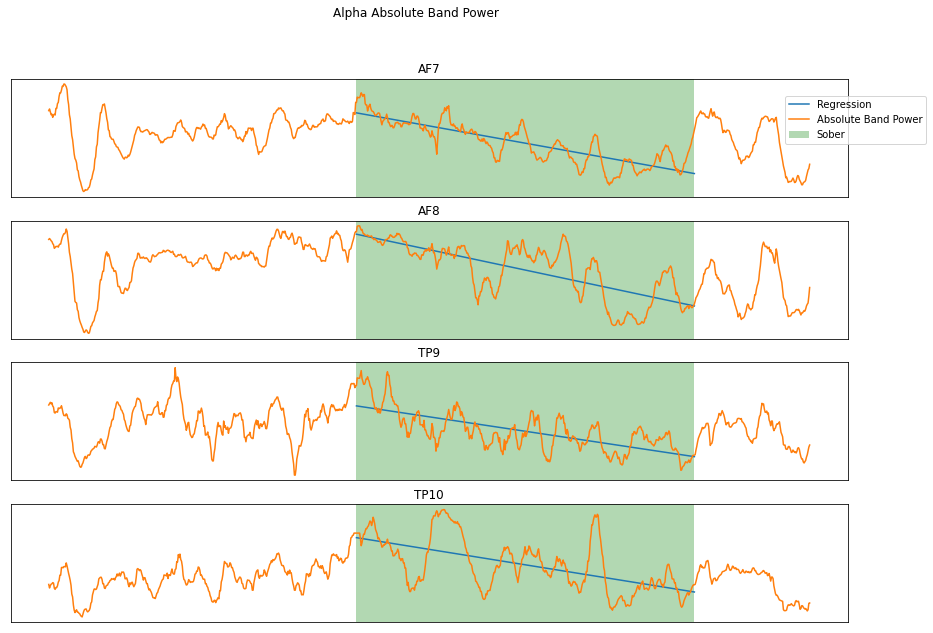

In [5]:
# Visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
for i, s in enumerate(ALPHA):
    vals = moving_avg(ses1[s],BATCH)
    # Time series Linear Regression
    y = vals[started_sober:stopped_sober]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([started_sober, stopped_sober], [b + c * 0, b + c * len(y)], label="Regression")
    # Brain Waves
    ax[i].plot(vals, label="Absolute Band Power")
    ax[i].set_title(sensors[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    # Sobriety
    ax[i].axvspan(started_sober, stopped_sober, facecolor='green', alpha=0.3, label="Sober")
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha Absolute Band Power")
plt.show()

We see a gradual decrease in the alpha waves across all sensors. This is consistent with the existing findings. To better visualize this decrease, we can implmement linear regression over the periods of sobriety. We see that each regression has a negative coefficient.

Like wise, with the proportionality increase of the alpha wave when high, we expect a decrease in proportionality elsewhere.

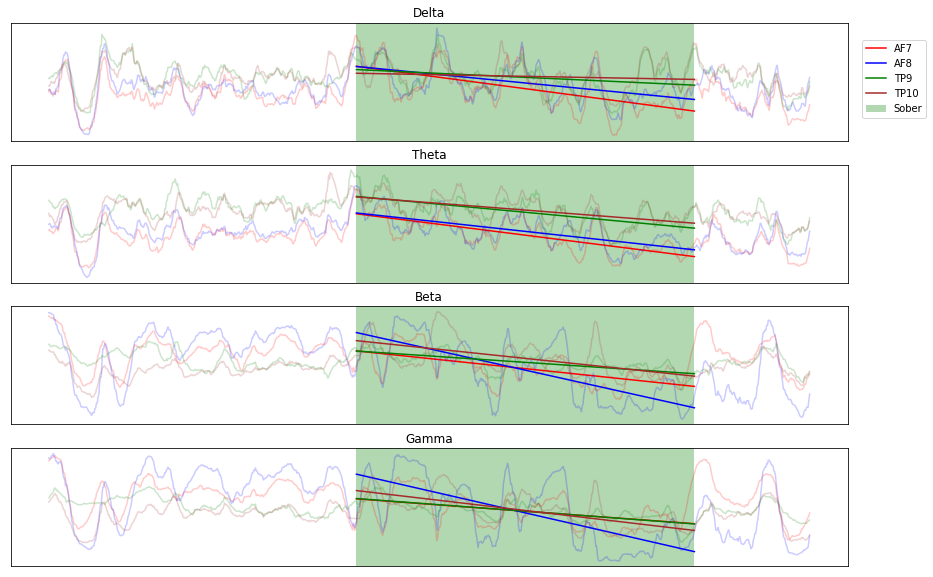

In [6]:
nonalphas = [DELTA, THETA, BETA, GAMMA]
titles = ["Delta", "Theta", "Beta", "Gamma"]
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
color = ["red", "blue", "green", "brown"]

for i, nonalpha in enumerate(nonalphas):
    # Visualization
    for j, s in enumerate(nonalpha):
        vals = moving_avg(ses1[s],BATCH)
        # Time series Linear Regression
        y = vals[started_sober:stopped_sober]
        X = np.arange(len(y)).reshape(-1, 1)
        c, b = getRegressionCoef(X,y)
        ax[i].plot([started_sober, stopped_sober], [b + c * 0, b + c * len(y)], label=sensors[j], c=color[j])
        # Brain Waves
        ax[i].plot(vals, alpha=.2, c=color[j])
    ax[i].set_title(titles[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    # Sobriety
    ax[i].axvspan(started_sober, stopped_sober, facecolor='green', alpha=0.3, label="Sober")
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.show()

We do not see this increase in nonalpha brainwaves, and rather a decrease throughout all the frequencies. Perhaps one reason is that this graph is not normalized. If we change the absolute to relative power band via the equation:
$$\text{relative_alpha} = \frac{10^\alpha}{\sum_{i=\alpha, \beta,\delta,\gamma,\theta}10^i}$$

we hopefully are able to visualize this change in proportionality

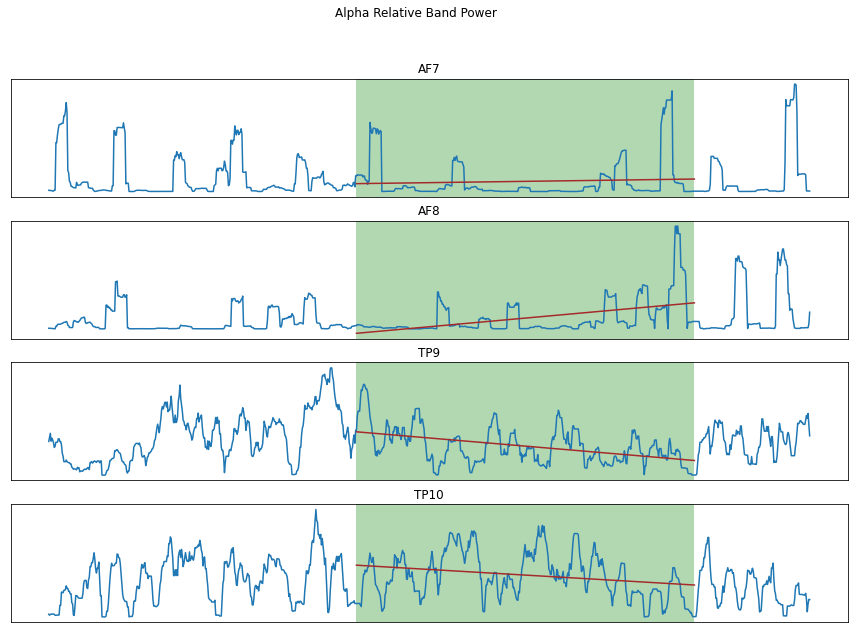

In [16]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
    alpha = ses1[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
    nonalphas = (ses1[sensor_names] ** 10).sum(axis=1)
    relative_alpha = alpha / nonalphas
    vals = moving_avg(relative_alpha, BATCH)
    ax[i].plot(vals)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(sensors[i])
    # Sobriety
    ax[i].axvspan(started_sober, stopped_sober, facecolor='green', alpha=0.3, label="Sober")

    # Time series Linear Regression
    y = vals[started_sober:stopped_sober]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([started_sober, stopped_sober], [b + c * 0, b + c * len(y)], label=sensors[j], c=color[j])
plt.suptitle("Alpha Relative Band Power")
plt.show()
    

Unfortunately, we are unable to replicate the decrease in alpha waves. We will procceed to other the sessions and hopefully the other sessions will hold the signal we are looking for.

### Session Two

|time|action|
|-|-|
|0:00-6:36| normal breathing focusing on nothing|
|6:36-6:40| stressful thought|
|6:45-7:00| writing|
|8:45-9:15| focussed on clock|
|9:15-9:30| writing|
|9:30-10:25| normal breathing focusing on nothing|
|10:25| picked up vape and inhaled|
|10:45| picked up vape and inhaled (swallowed)|
|11:25| picked up vape and inhaled|
|11:45| picked up vape and inhaled (swallowed)|
|11:45-15:00| Continued to vape every minute until 15:00|
|15:00-20:00| normal breathing focusing on nothing|
|20:00| end writing|

|external variable| description|
|-|-|
|Setting| In my living room, sitting at my desk|
|Ambient noise| Birds chirping
|Vape used| Smok Novo X at 24watts|
|Salt Nicotine used|  50mg Apple by Reds|

We will be conducting the same visual tests from session one.


In [13]:
ses2 = pd.read_csv(session_two_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses2.TimeStamp[0]
m2 = ses2.TimeStamp[0] + timedelta(seconds=60 * 10 + 25)
m3 = ses2.TimeStamp[0] + timedelta(seconds=60*15)
m4 = ses2.TimeStamp.iloc[-1]

sober1 = [sum(ses2.TimeStamp < m1), sum(ses2.TimeStamp < m2)]
sober2 = [sum(ses2.TimeStamp < m3), sum(ses2.TimeStamp < m4)]

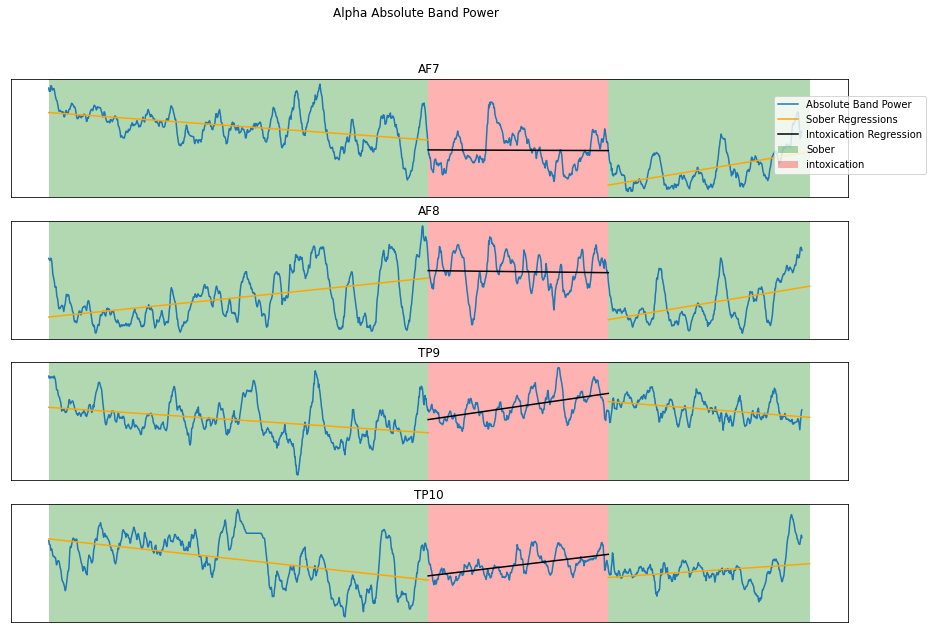

In [23]:
# Visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
for i, s in enumerate(ALPHA):
    vals = moving_avg(ses2[s],BATCH)
    # Brain Waves
    ax[i].plot(vals, label="Absolute Band Power")
    ax[i].set_title(sensors[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor='green', alpha=0.3, label="Sober")
    ax[i].axvspan(sober2[0], sober2[1], facecolor='green', alpha=0.3)
    # High
    ax[i].axvspan(sober1[1], sober2[0], facecolor='red', alpha=0.3, label="intoxication")
    # Time series Linear Regression step
    y = vals[sober1[0]:sober1[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober1[0], sober1[1]], [b + c * 0, b + c * len(y)], color="orange", label="Sober Regressions")

    y = vals[sober2[0]:sober2[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober2[0], sober2[1]], [b + c * 0, b + c * len(y)], color="orange")
    
    y = vals[sober1[1]:sober2[0]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober1[1], sober2[0]], [b + c * 0, b + c * len(y)], color="black", label="Intoxication Regression")

plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha Absolute Band Power")
plt.show()

Theres no general pattern to be found in the data. The slight positive coefficients during intoxication is small enough to be chance, and not seen in the AF regions. Will check the relative power and see if the data looks better there.

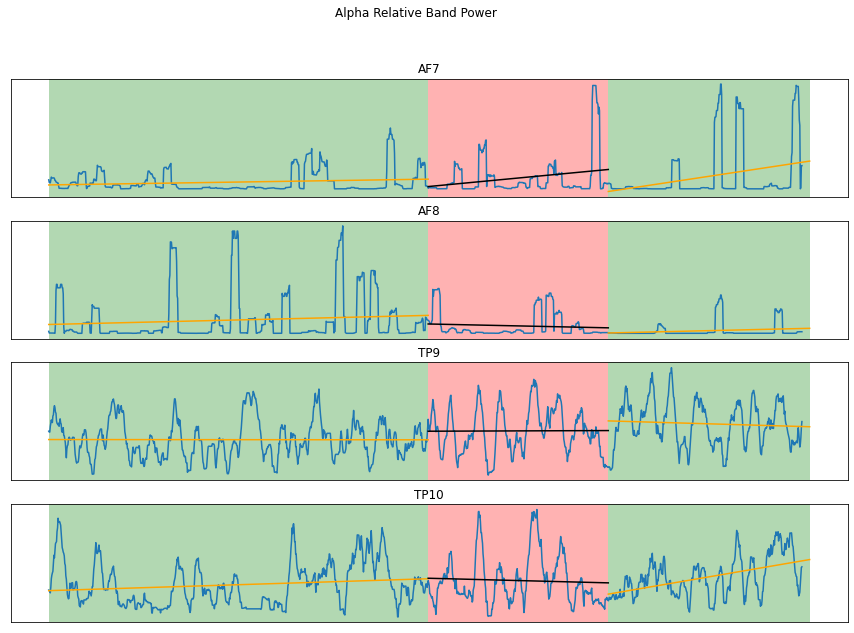

In [24]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
    alpha = ses2[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
    nonalphas = (ses2[sensor_names] ** 10).sum(axis=1)
    relative_alpha = alpha / nonalphas
    vals = moving_avg(relative_alpha, BATCH)
    ax[i].plot(vals)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(sensors[i])
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor='green', alpha=0.3, label="Sober")
    ax[i].axvspan(sober2[0], sober2[1], facecolor='green', alpha=0.3)
    # High
    ax[i].axvspan(sober1[1], sober2[0], facecolor='red', alpha=0.3, label="intoxication")

    # Time series Linear Regression step
    y = vals[sober1[0]:sober1[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober1[0], sober1[1]], [b + c * 0, b + c * len(y)], color="orange", label="Sober Regressions")

    y = vals[sober2[0]:sober2[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober2[0], sober2[1]], [b + c * 0, b + c * len(y)], color="orange")
    
    y = vals[sober1[1]:sober2[0]]
    X = np.arange(len(y)).reshape(-1, 1)
    c, b = getRegressionCoef(X,y)
    ax[i].plot([sober1[1], sober2[0]], [b + c * 0, b + c * len(y)], color="black", label="Intoxication Regression")
plt.suptitle("Alpha Relative Band Power")
plt.show()
    

Once more, no visual indications that signal is present in session two. W

### Session Three

|time|action|
|-|-|
|12:18-12:21| no nic|
|12:21-12:24| nic|
|12:24-12:27| no nic|

|external variable| description|
|-|-|
|Setting| Sitting at a chair, minimal movement, consistent and similar intervals of breath|
|Vape| Puff Bar Liche Ice|

According to Frederick, he felt the effects of niccotine most strongly in session three.